<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "5C"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/5C/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


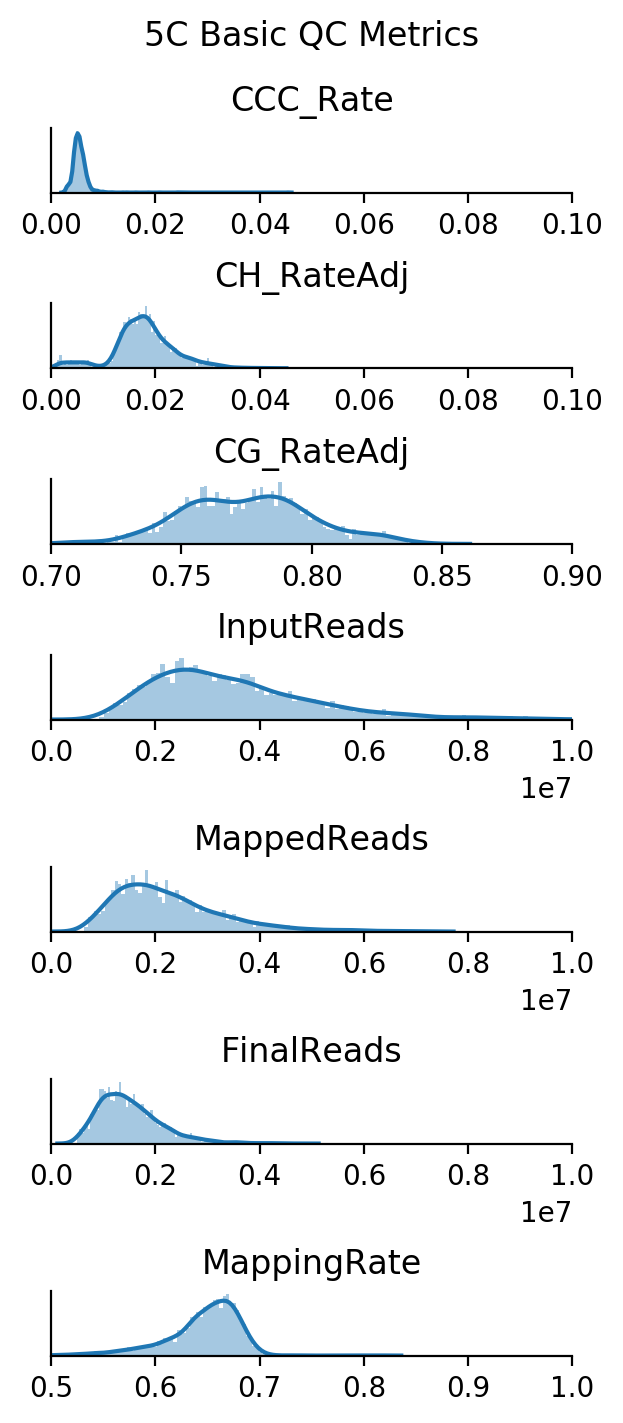

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

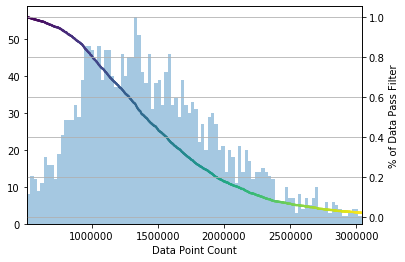

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2329/2329 (100.0%)
CG_RateAdj passed 2329/2329 (100.0%)
CH_RateAdj passed 2329/2329 (100.0%)
FinalReads passed 2329/2329 (100.0%)
MappingRate passed 2329/2329 (100.0%)
Overall passed 2329/2329 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
181002 1148
181210 1181


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 270 70.3%
ad002 308 80.2%
ad004 288 75.0%
ad006 291 75.8%
ad007 292 76.0%
ad008 288 75.0%
ad010 295 76.8%
ad012 297 77.3%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
5C_M_0,/gale/raidix/rdx-4/mapping/5C/CEMBA181002-5C-5...,0.003784,0.759943,0.759031,0.017393,0.013661,1068870.0,2104488,1395099.0,5C,...,5.066007,-17.062212,-39.208147,5.432372,IT-L4 Astn2,2.531947,3.850476,0.792984,-5.002672,True
5C_M_1,/gale/raidix/rdx-4/mapping/5C/CEMBA181002-5C-5...,0.004502,0.782769,0.781787,0.022833,0.018414,1106389.0,2169944,1466529.0,5C,...,16.512505,-9.291677,11.866353,0.975199,IT-L6 Cadps2,0.303843,-2.350520,-33.007669,11.562024,True
5C_M_10,/gale/raidix/rdx-4/mapping/5C/CEMBA181002-5C-5...,0.005368,0.796460,0.795362,0.025170,0.019908,1466304.0,3103724,2044981.0,5C,...,14.626056,-9.230639,1.186517,2.903896,IT-L6 Man1c1,-1.426923,-7.116673,-25.285112,-11.683353,True
5C_M_1000,/gale/raidix/rdx-4/mapping/5C/CEMBA181002-5C-7...,0.003015,0.749647,0.748890,0.006397,0.003393,3476012.0,8265036,5593120.0,5C,...,-6.111117,7.246611,-6.807178,-11.135535,ASC mid,4.094004,0.757997,-7.462034,2.485033,True
5C_M_1001,/gale/raidix/rdx-4/mapping/5C/CEMBA181002-5C-7...,0.006446,0.781808,0.780392,0.034478,0.028214,1918157.0,4509224,3023781.0,5C,...,10.651448,11.187014,53.031593,27.557271,PT-L5 Kcnh1,-8.936400,6.898907,12.362383,-24.820743,True
5C_M_1002,/gale/raidix/rdx-4/mapping/5C/CEMBA181002-5C-7...,0.004744,0.763883,0.762758,0.020781,0.016114,1982839.0,4581436,3036015.0,5C,...,3.700282,-14.700287,-32.156492,11.294918,IT-L4 Shc3,-2.260861,-0.153089,-7.475703,30.925144,True
5C_M_1003,/gale/raidix/rdx-4/mapping/5C/CEMBA181002-5C-7...,0.005094,0.782779,0.781667,0.022413,0.017408,2096425.0,5029476,3278830.0,5C,...,15.229603,-7.943901,-0.570873,-1.408791,IT-L6 Man1c1,-2.417002,-10.092992,-20.141441,-24.476134,True
5C_M_1004,/gale/raidix/rdx-4/mapping/5C/CEMBA181002-5C-7...,0.005150,0.776155,0.774997,0.022998,0.017940,2448343.0,5942438,3799194.0,5C,...,16.986767,-7.071908,8.169488,-4.121736,IT-L6 Cadps2,-3.342257,-6.104342,-15.074050,-3.260871,True
5C_M_1005,/gale/raidix/rdx-4/mapping/5C/CEMBA181002-5C-7...,0.006307,0.825974,0.824869,0.032933,0.026795,2241480.0,5511288,3474108.0,5C,...,23.406893,15.164462,23.169028,54.895664,L6b Kcnk2,13.429564,10.192626,-20.037538,-9.745403,True
5C_M_1006,/gale/raidix/rdx-4/mapping/5C/CEMBA181002-5C-7...,0.006093,0.796795,0.795549,0.033242,0.027315,2102119.0,4850062,3302876.0,5C,...,-25.138113,4.724180,1.213967,-39.883785,MGE-Pvalb Sema5a,-2.232622,-9.251121,-2.487598,2.161645,True
